## Derivatives Pricing

The goal of this case study is to perform derivative pricing from a machine learning standpoint and use supervised regression-based model to learn the Black-Scholes option pricing model from simulated data.


<a id='0'></a>
# 1. Problem Definition

In the supervised regression framework used for this case study, the derivative pricing
problem is defined in the regression framework, where the predicted variable is the
pricing of the option, and the predictor variables are the market data that are used as
inputs to the Black-Scholes option pricing model

Options have been used in finance as means to hedge risk in a nonlinear manner. They are are also used by speculators in order to take leveraged bets in the financial markets. Historically, people have used the Black Scholes formula.

$$  Se^{-q \tau}\Phi(d_1) - e^{-r \tau} K\Phi(d_2) \, $$

With

$$  d_1 = \frac{\ln(S/K) + (r - q + \sigma^2/2)\tau}{\sigma\sqrt{\tau}}  $$

and

$$  d_2 = \frac{\ln(S/K) + (r - q - \sigma^2/2)\tau}{\sigma\sqrt{\tau}} = d_1 - \sigma\sqrt{\tau}  $$

Where we have;
    Stock price $S$;
    Strike price $K$;
    Risk-free rate $r$;
    Annual dividend yield $q$;
    Time to maturity $\tau = T-t$ (represented as a unit-less fraction of one year);
    Volatility $\sigma$

In order to make the logic simpler, we define *Moneyness* as $M = K/S$ and look at the prices in terms of per unit of current stock price. We also set $q$ as $0$ 

This simplifes the formula down to the following

$$  e^{-q \tau}\Phi\left( \frac{- \ln(M) + (r+ \sigma^2/2 )\tau}{\sigma\sqrt{\tau}}\right) - e^{-r \tau} M\Phi\left( \frac{- \ln(M) + (r - \sigma^2/2)\tau}{\sigma\sqrt{\tau}} \right) \, $$

### Vol Suface

In the options market, there isn't a single value of volatility which gives us the correct price. We often find the volatility such that the output matches the price

### Simulation

In this exercise, we assume the the structure of the vol surface. In practice, we would source the data from a data vendor.


We use the following function to generate the option volatility surface

$$ \sigma(M, \tau) = \sigma_0 + \alpha\tau + \beta (M - 1)^2$$

<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

<a id='1.1'></a>
## 2.1. Loading the python packages

### Python Imports

In [18]:
import os
import sys

root_dir = os.path.abspath('../..')
sys.path.append(root_dir)
from functions import (
    ParamsKfold, ResultKfold, ParamsGridSearch, 
    calc_best_features, run_kfold_analysis, run_grid_search, show_corr_matrix, show_scatter_matrix, 
    show_seasonal_decomposition, show_boxplot_kfold, show_bar_kfold
)
from case_study_2 import ParamsCallOPtion, calc_opt_volatility, calc_opt_price

In [2]:
# Core libraries

import numpy as np
import pandas as pd
import pandas_datareader.data as web
import seaborn as sns
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

# Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasRegressor

# Distribution functions
from scipy.stats import norm

# Libraries for Statistical Models
import statsmodels.api as sm

# Libraries for Saving the Model
from pickle import load, dump

# Time series Models
from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.tsa import SARIMAX

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import chi2, f_regression, SelectKBest

# Plotting 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf


2022-10-06 15:00:55.693433: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-06 15:00:55.693479: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# Disable the warnings

import warnings
warnings.filterwarnings('ignore')


<a id='1.3'></a>
## 2.3. Data Generation

In [4]:
N = 10000 # Number of data points
params_call_opt = ParamsCallOPtion(true_alpha=0.1, true_beta=0.1, true_sigma0=0.2, risk_free_rate=0.0)
Moneynesses = 1 + (0.25 * np.random.randn(N))
Times_to_mat = np.random.random(N)

Sigmas = calc_opt_volatility(Moneynesses, Times_to_mat, params_call_opt)
Prices = calc_opt_price(Moneynesses, Times_to_mat, Sigmas, params_call_opt)


### Set the Endog and Exog Data

In [5]:
X = pd.DataFrame({'Moneyness': Moneynesses, 'Time': Times_to_mat, 'Volatility': Sigmas})
Y = pd.DataFrame({'Price': Prices})

dataset = pd.concat([Y, X], axis=1).fillna(0.0)

<a id='2'></a>
# 3. Exploratory Data Analysis

<a id='2.1'></a>
## 3.1. Descriptive Statistics

In [6]:
dataset.head()

,Price,Moneyness,Time,Volatility
0,0.023102,1.135598,0.197951,0.221634
1,0.103927,1.017237,0.354900,0.235520
2,0.123132,1.251019,0.880300,0.294331
3,0.091477,0.991804,0.241608,0.224167
4,0.258800,0.893489,0.896157,0.290750


In [7]:
dataset.describe()

,Price,Moneyness,Time,Volatility
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.168371,0.998119,0.498242,0.256077
std,0.132500,0.250067,0.289241,0.030216
min,0.000000,0.116886,0.000099,0.200129
25%,0.066464,0.831324,0.247683,0.230929
50%,0.147511,0.997902,0.493777,0.255668
75%,0.241245,1.166924,0.749627,0.281084
max,0.883114,1.985351,0.999994,0.366483


<a id='2.2'></a>
## 3.2. Data Visualization

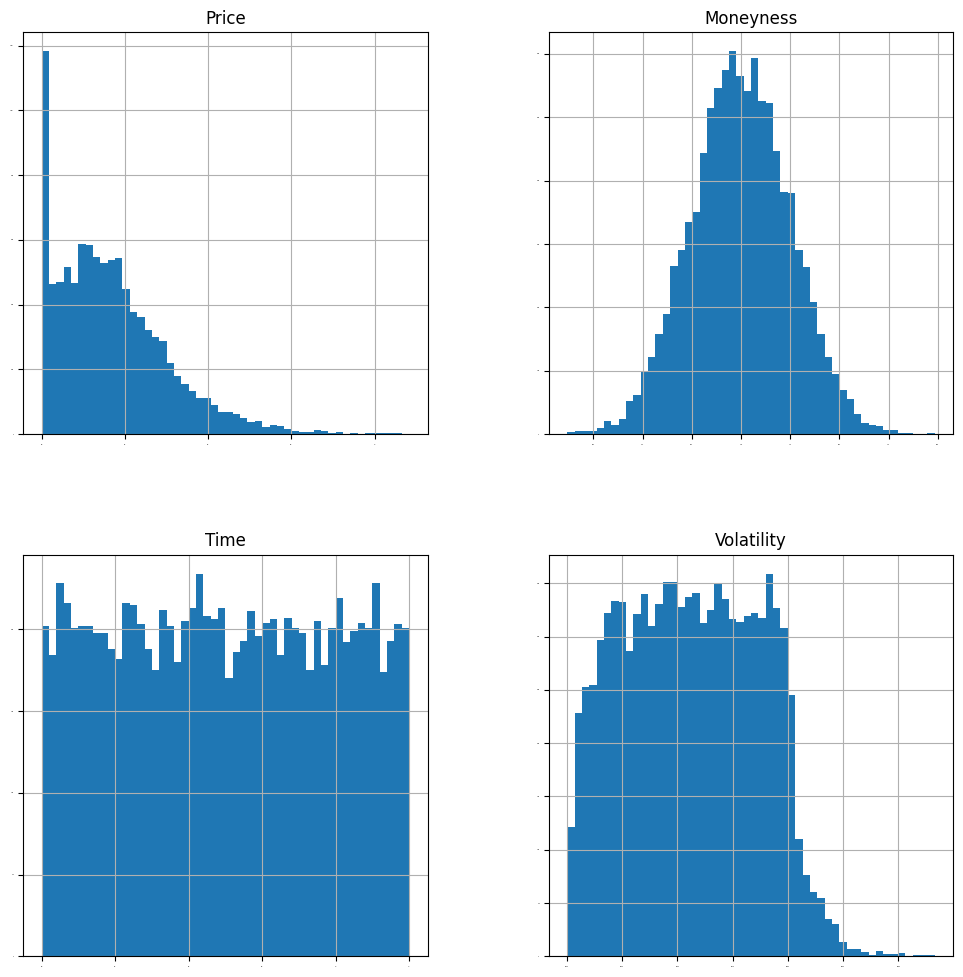

In [8]:
dataset.hist(
    bins=50, 
    sharex=False, 
    sharey=False, 
    xlabelsize=1, 
    ylabelsize=1, 
    figsize=(12, 12)
)
pyplot.show()


We can see that the price has an interesting distribution with a spike at $0$

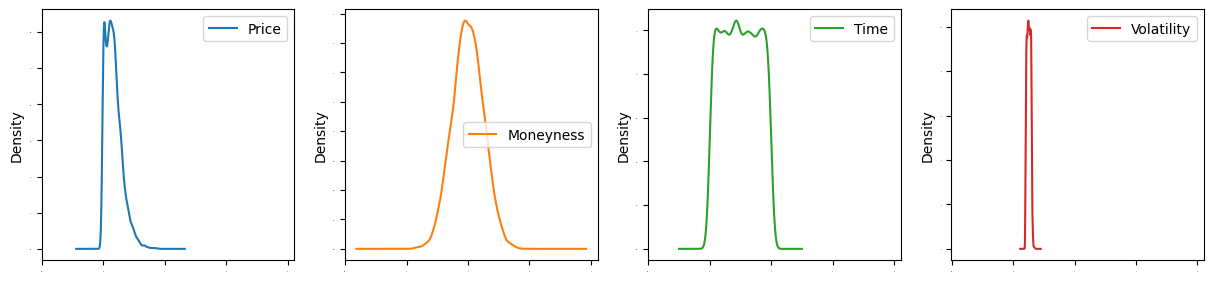

In [9]:
dataset.plot(
    kind='density', 
    subplots=True, 
    layout=(4, 4), 
    sharex=True, 
    legend=True, 
    fontsize=1, 
    figsize=(15, 15)
)
pyplot.show()


Next we look at the interaction between different variables

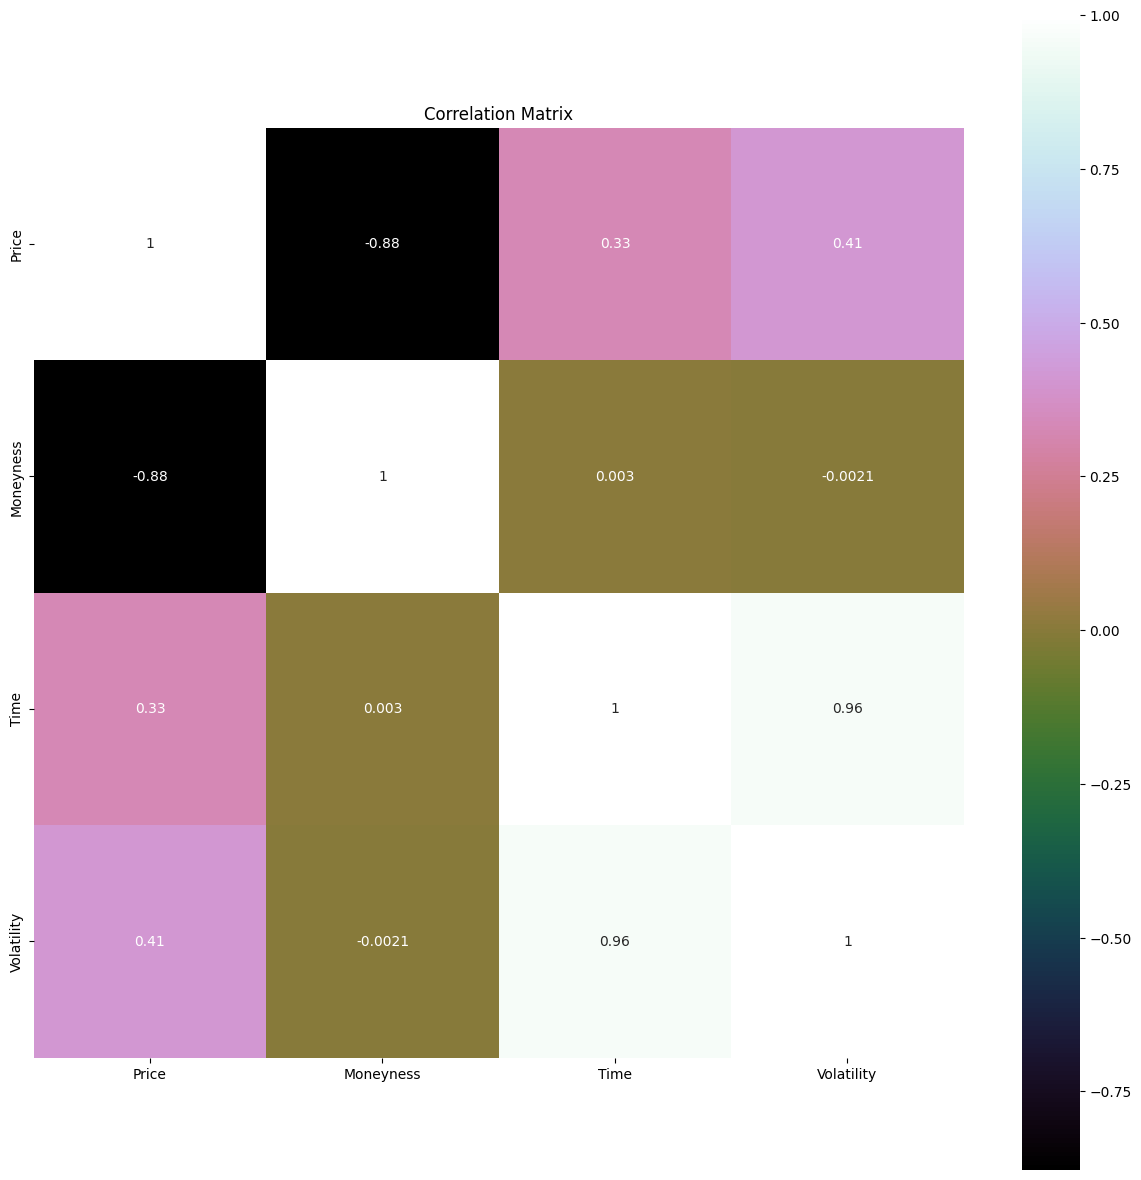

In [10]:
show_corr_matrix(dataset)


<Figure size 1500x1500 with 0 Axes>

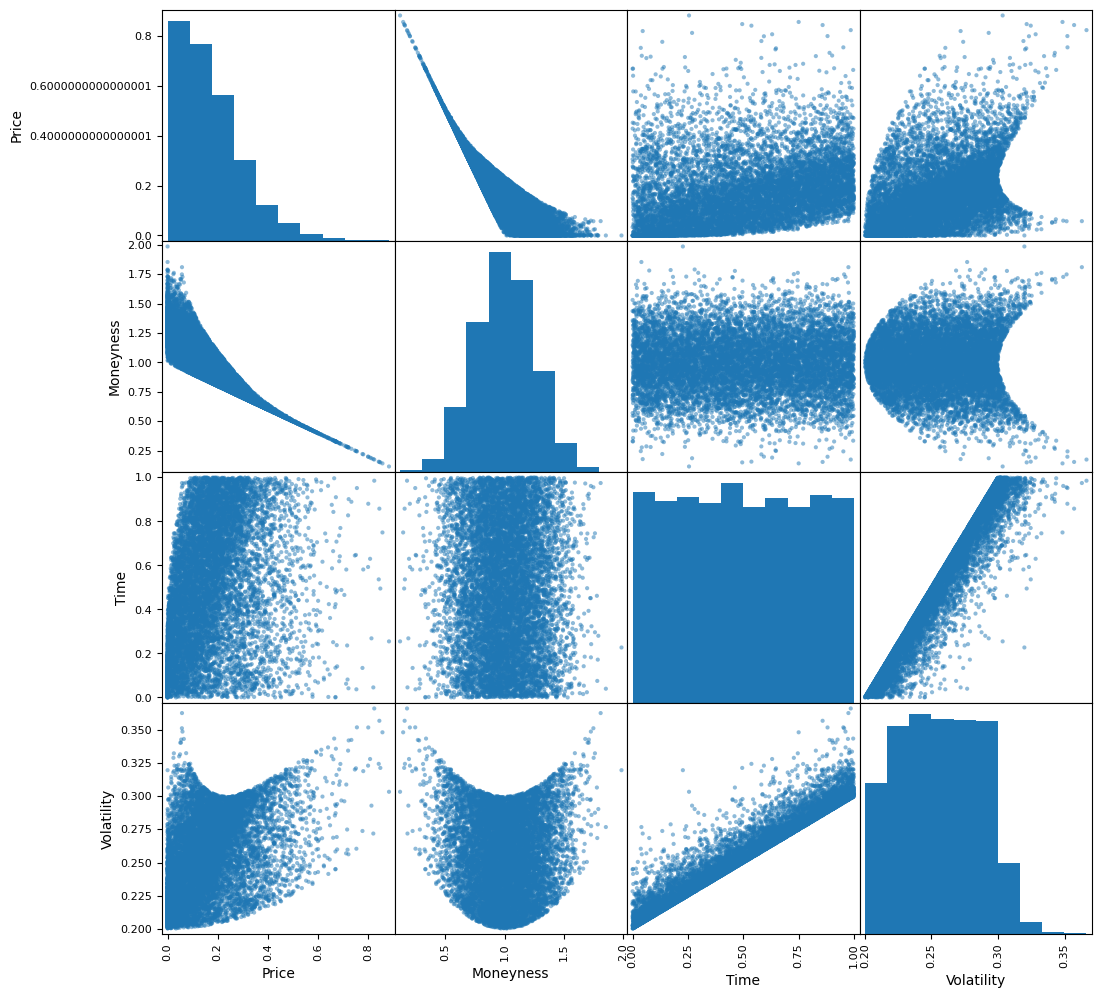

In [11]:
show_scatter_matrix(dataset)


We see some very interesting non linear analysis. This means that we expect our non linear models to do a better job than our linear models.

<a id='3'></a>
## 4. Data Preparation and Analysis

<a id='4.1'></a>
## 4.1. Univariate Feature Selection

We use SelectKBest function from sklearn

In [12]:
calc_best_features(X, Y, n_features='all')


----------------------------------------------------------------
                   Score
Specs                   
Moneyness   33595.166550
Volatility   1997.143162
Time         1190.026094


We observe that the moneyness is the most important variable for the price.

<a id='4'></a>
# 5. Evaluate Algorithms and Models

<a id='4.1'></a>
## 5.1. Train Test Split and Evaluation Metrics

In [13]:
validation_size = 0.2
train_size = int(len(X) * (1 - validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]
models = [
    # Linear methods
    ('LR', LinearRegression()),
    ('LASSO', Lasso()),
    ('EN', ElasticNet()),
    ('KNN', KNeighborsRegressor()),
    ('CART', DecisionTreeRegressor()),
    ('SVR', SVR()),

    # Neural network method
    ('MLP', MLPRegressor()),

    # Boosting and Bagging methods
    ('ABR', AdaBoostRegressor()),
    ('GBR', GradientBoostingRegressor()),
    ('RFR', RandomForestRegressor()),
    ('ETR', ExtraTreesRegressor()),
]

params = ParamsKfold(
    models=models,
    X_train=X_train,
    Y_train=Y_train,
    X_test=X_test,
    Y_test=Y_test,
    num_folds=10,
    scoring='neg_mean_squared_error',
    seed=7,
    shuffle=True,
)


<a id='4.2'></a>
## 5.2. Compare Models and Algorithms

#### Linear Models and Regression Trees

In [14]:
kfold_results = run_kfold_analysis(params)


LR: 0.000356 (0.000020) 0.000355 0.000343
LASSO: 0.017527 (0.000946) 0.017522 0.017684
EN: 0.017527 (0.000946) 0.017522 0.017684
KNN: 0.000017 (0.000006) 0.000009 0.000012
CART: 0.000008 (0.000001) 0.000000 0.000006
SVR: 0.004790 (0.000195) 0.004802 0.004740
MLP: 0.000035 (0.000017) 0.000047 0.000044
ABR: 0.000622 (0.000029) 0.000580 0.000598
GBR: 0.000017 (0.000001) 0.000013 0.000017
RFR: 0.000002 (0.000001) 0.000000 0.000001
ETR: 0.000001 (0.000001) 0.000000 0.000000


We begin by looking at the Kfold analysis

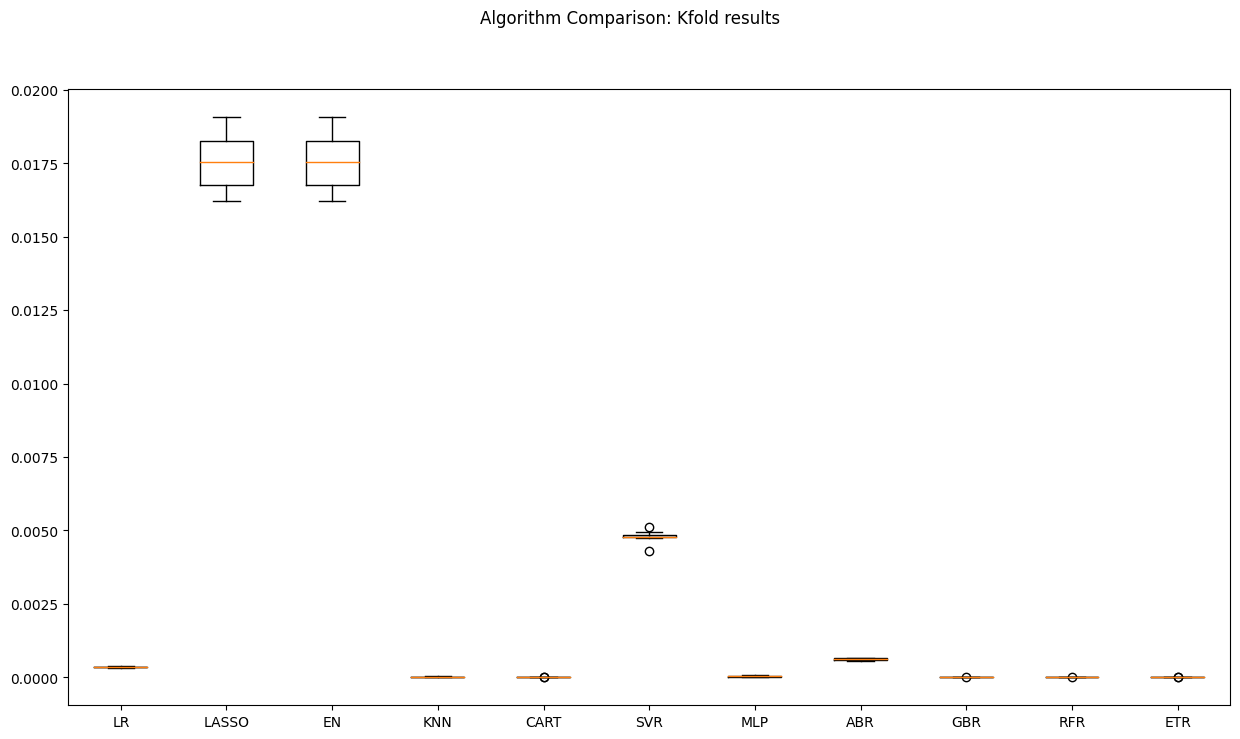

In [15]:
show_boxplot_kfold(kfold_results)

In order to get a better view, we remove the LASSO and Elastic Net

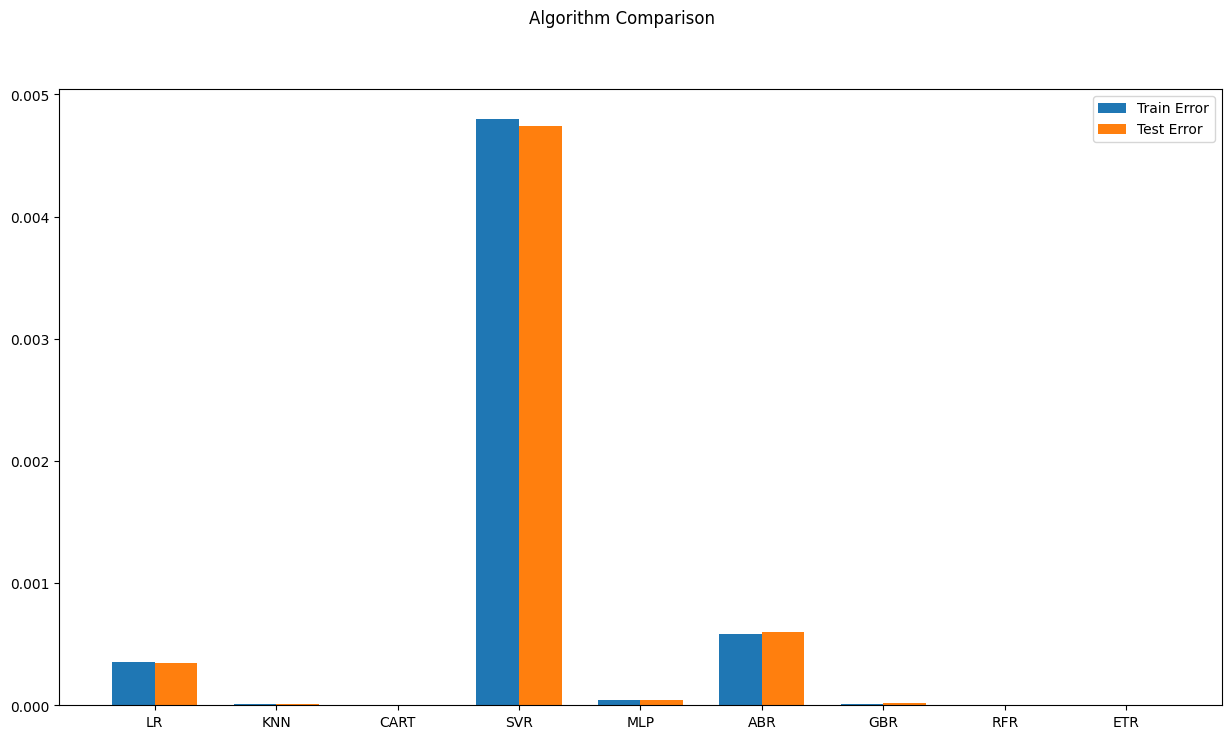

In [16]:
kfold_results.train_results = kfold_results.train_results[0:1] + kfold_results.train_results[3:]
kfold_results.test_results = kfold_results.test_results[0:1] + kfold_results.test_results[3:]
kfold_results.names = kfold_results.names[0:1] + kfold_results.names[3:]

show_bar_kfold(kfold_results)

We see that the multilayer perceptron (MLP) algorithm does a lot better that the linear algorithm. However, the CART and the Forest methods do a very good job as well. Given MLP is one of the best models we perform the grid search for MLP model in the next step.  

<a id='5'></a>
# 6. Model Tuning and finalising the model

As shown in the chart above the MLP model is one of the best models, so we perform the model tuning. We perform a grid search with different combination of hidden layers in the MLP model.  

In [19]:
params_search = ParamsGridSearch(
    model=MLPRegressor(),
    params_grid={'hidden_layer_sizes': [(20,), (50,), (20, 20), (20, 30, 20)]},
    X_train=X_train,
    Y_train=Y_train,
    X_test=X_test,
    Y_test=Y_test,
    num_folds=10,
    scoring='neg_mean_squared_error',
    seed=7,
    shuffle=True,
)

search_results = run_grid_search(params_search)


Best: -0.000042 using {'hidden_layer_sizes': (20, 30, 20)}
-0.000600 (0.000450) with: {'hidden_layer_sizes': (20,)}
-0.000171 (0.000210) with: {'hidden_layer_sizes': (50,)}
-0.000106 (0.000067) with: {'hidden_layer_sizes': (20, 20)}
-0.000042 (0.000026) with: {'hidden_layer_sizes': (20, 30, 20)}


In [20]:
# Prepare model

model_tuned = MLPRegressor(hidden_layer_sizes=search_results.best_params_['hidden_layer_sizes'])
model_tuned.fit(X_train, Y_train)


MLPRegressor(hidden_layer_sizes=(20, 30, 20))

In [21]:
# Estimate accuracy on validation set. Transform the validation dataset

predictions = model_tuned.predict(X_test)
print(f'MSE error: {mean_squared_error(Y_test, predictions)}')


MSE error: 2.4331315973364797e-05


We see that the mean error is roughly less than a cent. Hence, the deep learning model does an excellent job of fitting the Black-Scholes option pricing model. The accuracy may be enhanced with more tuning.


<a id='6'></a>
# 7. Additonal analysis: removing the volatilty data

Next, we make the process harder by trying to predict the price without the volatility data.

In [22]:
X2 = X.drop(['Volatility'], axis=1)
validation_size = 0.2
total_size = X2.shape[0]
train_size = int(total_size * (1 - validation_size))

X_train, X_test = X2[0:train_size], X2[train_size:total_size]
Y_train, Y_test = Y[0:train_size], Y[train_size:total_size]


In [23]:
models = [
    # Linear methods
    ('LR', LinearRegression()),
    ('KNN', KNeighborsRegressor()),
    ('CART', DecisionTreeRegressor()),
    ('SVR', SVR()),

    # Neural network method
    ('MLP', MLPRegressor()),

    # Boosting and Bagging methods
    ('ABR', AdaBoostRegressor()),
    ('GBR', GradientBoostingRegressor()),
    ('RFR', RandomForestRegressor()),
    ('ETR', ExtraTreesRegressor()),
]


In [24]:
params = ParamsKfold(
    models=models,
    X_train=X_train,
    Y_train=Y_train,
    X_test=X_test,
    Y_test=Y_test,
    num_folds=10,
    scoring='neg_mean_squared_error',
    seed=7,
    shuffle=True,
)
kfold_results = run_kfold_analysis(params)


LR: 0.002153 (0.000169) 0.002149 0.002048
KNN: 0.000017 (0.000006) 0.000009 0.000012
CART: 0.000008 (0.000001) 0.000000 0.000007
SVR: 0.005974 (0.000136) 0.005863 0.005828
MLP: 0.000032 (0.000021) 0.000047 0.000042
ABR: 0.000638 (0.000032) 0.000630 0.000645
GBR: 0.000018 (0.000002) 0.000015 0.000019
RFR: 0.000002 (0.000001) 0.000000 0.000001
ETR: 0.000001 (0.000001) 0.000000 0.000000


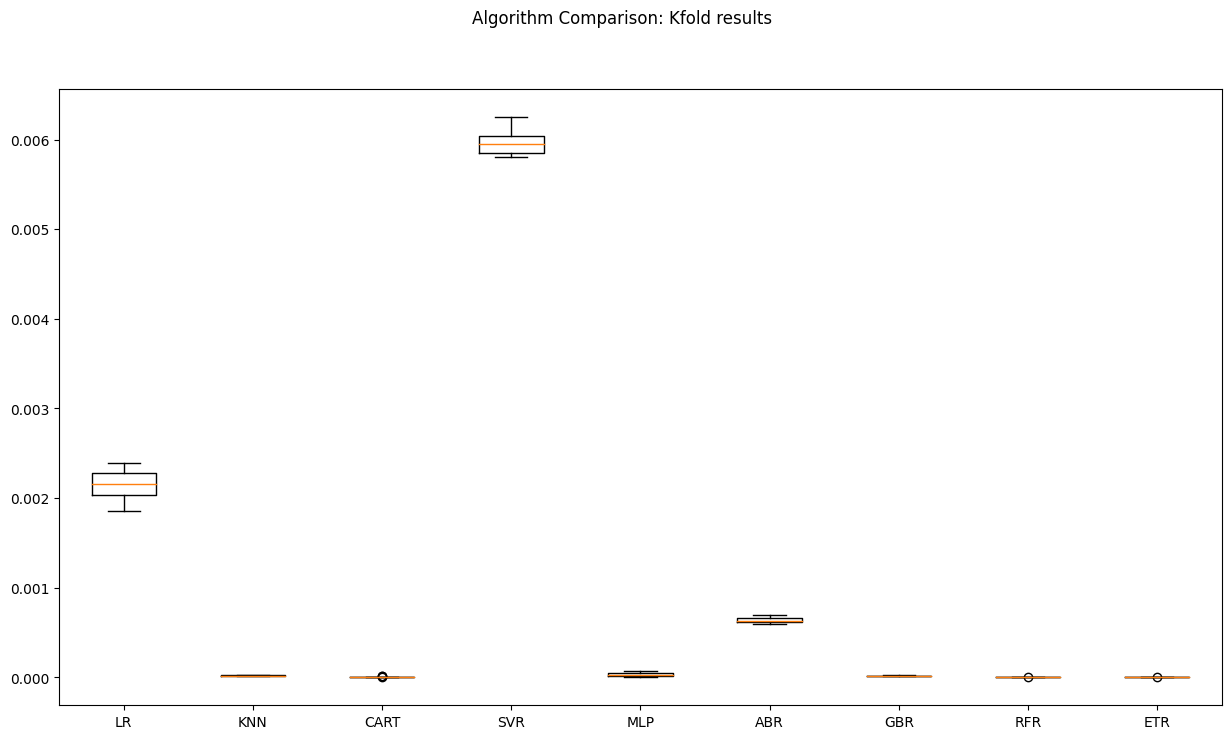

In [26]:
show_boxplot_kfold(kfold_results)


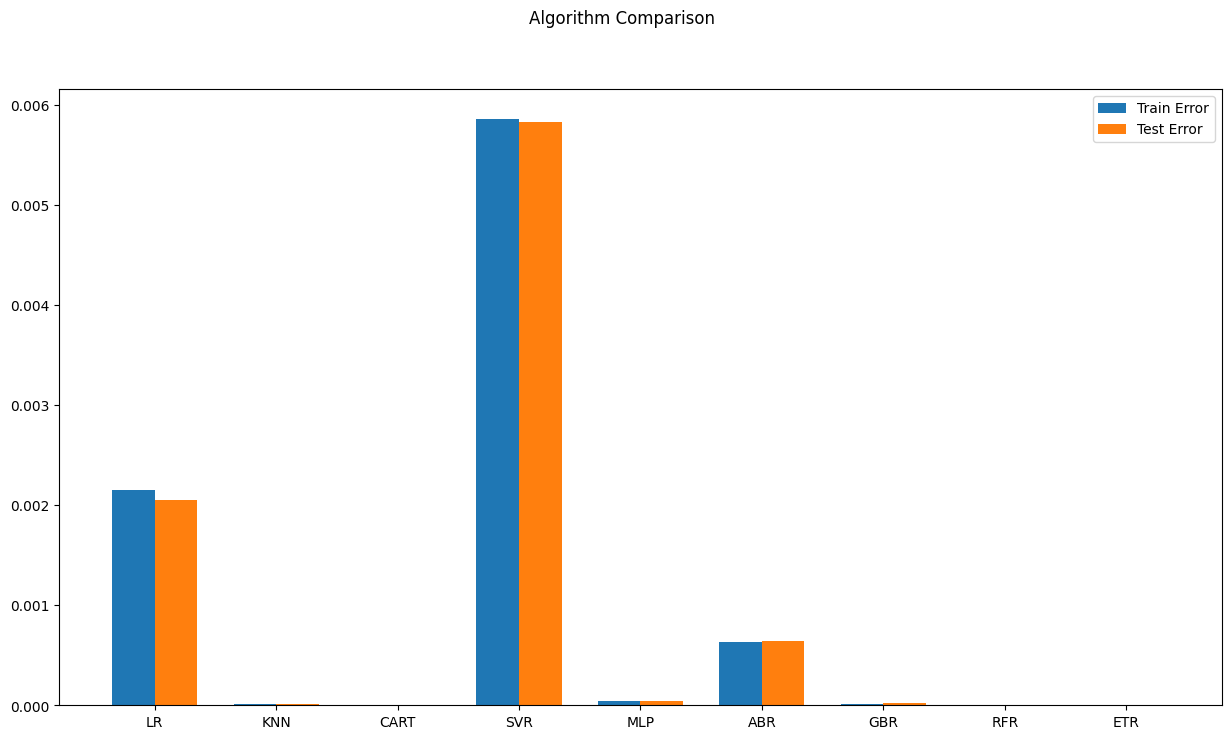

In [27]:
show_bar_kfold(kfold_results)

We can see that the linear regression now does a worse job than before, this is expected since we have added a greater amount of non linearity.

### Summary

* The linear regression model did not do as well as our non-linear models and the non-linear models
have a very good performance overall. 

* Artificial neural network (ANN) can reproduce the Black and Scholes
option pricing formula for a call option to a high degree of accuracy which means that we can leverage the efficient numerical calculation of machine learning in the derivative pricing without relying on the impractical assumptions made in the traditional
derivative pricing models. 